<a href="https://colab.research.google.com/github/1kruidenp/PRA3024/blob/master/Week_2_Interm_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is part 2 of the intermediate tutorials. 
Here the same is done for part 1 but with a new star. Only the adjusted things are commented.

In [35]:

!pip install astroquery
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

%matplotlib inline

from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()



In [36]:
ticid = 304100538 #Here the tic is changed to a new one

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
304100538  9.5268  8.918 27.6997875958083 -75.8487575073221    STAR
304100537  15.637 15.137        27.699642         -75.85025    STAR
630842911  20.687    nan 27.6752025676053 -75.8498383331674    STAR
630842931 19.6371    nan 27.7258880752989 -75.8459109716747    STAR
304100534 14.7729 14.082 27.7135993899199 -75.8560336947197    STAR


In [37]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

15

In [38]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-3      1      3   3
tess-s0002-3-3      2      3   3
tess-s0013-3-4     13      3   4


In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [40]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

In [41]:
hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1245R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

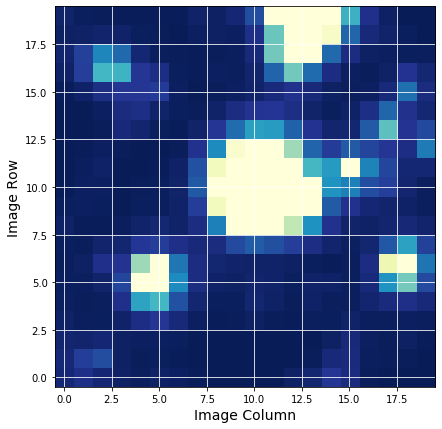

In [43]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)


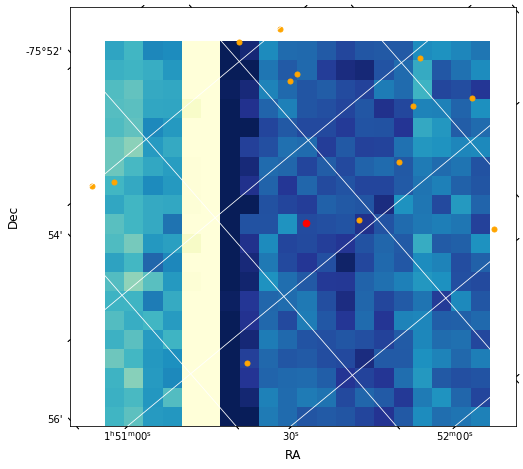

In [44]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header) #no HDU 2

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux


Text(0.5, 1.0, 'Flux in Photometric Aperture')

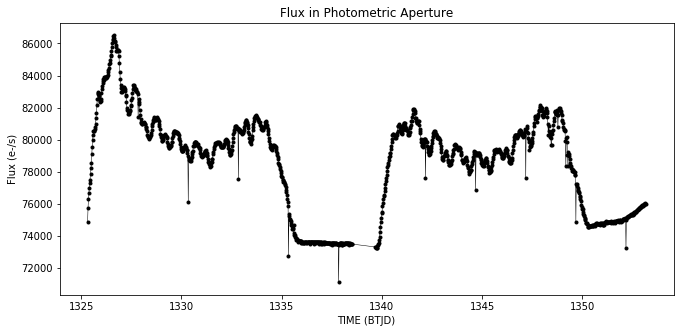

In [46]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)

plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Text(0.5, 1.0, 'Background Flux')

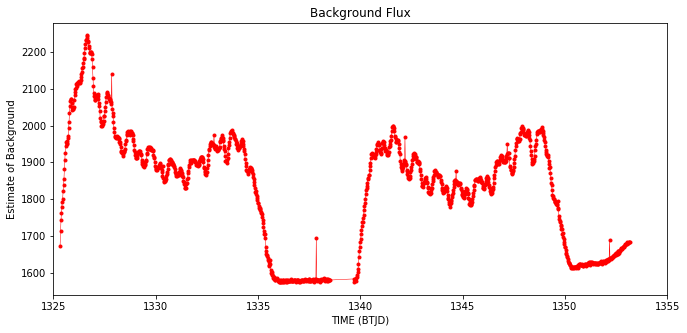

In [47]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1355)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

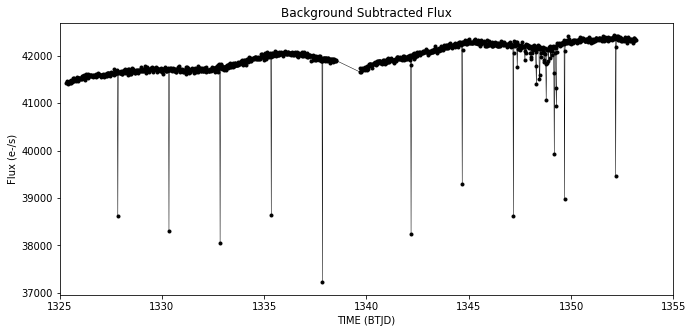

In [48]:

from scipy.signal import argrelextrema

bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )


plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1355)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')





Text(0.5, 1.0, 'Periodogram(TIC33878688)')

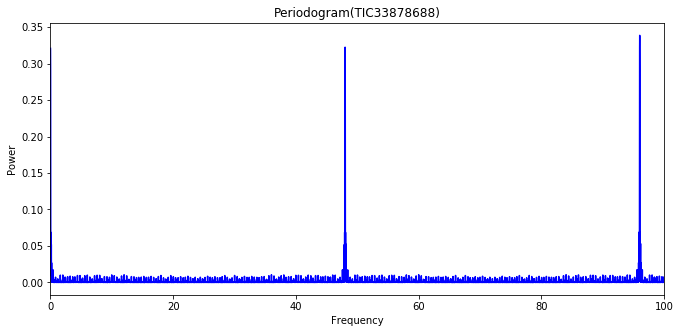

In [49]:

frequency, power = LombScargle(time1, bkgSubFlux).autopower(maximum_frequency=100)


plt.figure(figsize= (11, 5))
                   

plt.plot(frequency, power,'b')


# Labeling the axes
plt.xlim(0,100)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram(TIC304100538)')



Text(0.5, 1.0, 'Periodogram(TIC33878688)')

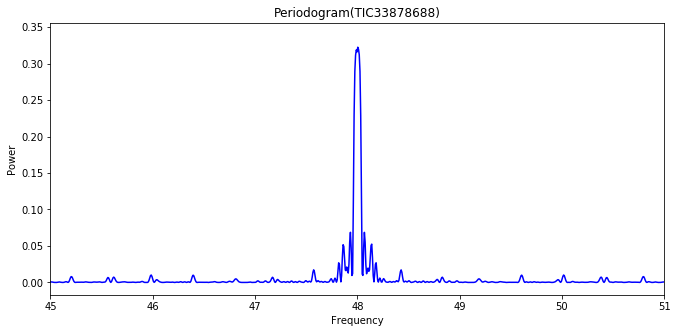

In [52]:
#Within the graph above, you see a peak around 48 as well, which is weird as we got the same result in Part 1. 
#Also in the graph of Background subtracted flux, you can see that there is a sudden drop of 5 times in about 10 days.
#This should also result in a frequency of 48 when converted to per hour. 
#It is extremely strange that the same result is found for both part 1 and 2 though, and so maybe this frequency has something to do with the recording
#of TESS and not with the period of the star.

frequency, power = LombScargle(time1, bkgSubFlux).autopower(maximum_frequency=100)


plt.figure(figsize= (11, 5))
                   

plt.plot(frequency, power,'b')


# Labeling the axes
plt.xlim(45,51)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram(TIC304100538)')
